# Wordle Solver

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Prepare Data

You can use any list of five letter words. In this example we use a list of German words from [this repository](https://github.com/ic3gr33dy/Wordle_DE).

In [2]:
df=pd.read_csv('wordle_de.csv')
df['Wort']=df['Wort'].str.lower()
df

,Wort
0,aalen
1,abart
2,abbat
3,abbau
4,abbog
...,...
1815,zwerg
1816,zwirn
1817,zwist
1818,zwölf


First we split the words into single letters...

In [3]:
df_split=df['Wort'].apply(lambda x: pd.Series(list(x)))
df_split.head()

,0,1,2,3,4
0,a,a,l,e,n
1,a,b,a,r,t
2,a,b,b,a,t
3,a,b,b,a,u
4,a,b,b,o,g


...and join the words and letters afterwards.

In [4]:
df=pd.merge(df, df_split, left_index=True, right_index=True)
df

,Wort,0,1,2,3,4
0,aalen,a,a,l,e,n
1,abart,a,b,a,r,t
2,abbat,a,b,b,a,t
3,abbau,a,b,b,a,u
4,abbog,a,b,b,o,g
...,...,...,...,...,...,...
1815,zwerg,z,w,e,r,g
1816,zwirn,z,w,i,r,n
1817,zwist,z,w,i,s,t
1818,zwölf,z,w,ö,l,f


## Calculate Probabilities

To find the searched word as fast as possible we sort the words according to their probability.

First, we calculate the probability of each single letter of appearing in the searched word at a certain position. Next we calculate the probability of entire words being the searched word.

The probabilities are updated after each attempt (after a new word was entered by the user)

In [5]:
def get_probs(df):
    """retruns a list of words sorted by their probability of being the searched word

    Args:
        df (dataframe): Dataframe with possible words

    Returns:
        dataframe
    """
    #calculate probability of appearance of letters
    prob={}
    df.reset_index(drop=True, inplace=True) #reset the index to fit to the dict created later
    word_count=len(df) #get the number of words
    for i in [0,1,2,3,4]: #loop through the positions of a word
        prob[i]={}
        for char,count in df[i].value_counts().items(): #get the number of appearances of each letter at position i
            prob[i][char]=count/word_count #calculate the probability of the letter to appear at position i

    #calculate the probability of the given letters
    prob_given={}
    for i in [0,1,2,3,4]: #loop through the letters of a word
        prob_given[i]=[]
        for index,char in df[i].items():
            prob_given[i].append(prob[i][char]) #add probability of letter i to array


    df_probs=pd.DataFrame.from_dict(prob_given) #convert array to dataframe
    df=df[['Wort',0,1,2,3,4]] #get neccessary data from the initial dataframe
    
    df=pd.merge(df, df_probs, left_index=True, right_index=True) #merge initial dataframe with calculated probabilities
    df.rename(columns={'0_x':0,'1_x':1,'2_x':2,'3_x':3,'4_x':4}, inplace=True)
    
    #calculate probability of each word being the searched word
    df['total_prob']=(df['0_y']+df['1_y']+df['2_y']+df['3_y']+df['4_y'])/5
    df['total_prob']=(1/df['total_prob'].sum())*df['total_prob']
    
    #sort words by probability
    df=df.sort_values('total_prob', ascending=False)
    
    return df

Let's have a look at the result:

In [6]:
df_all=get_probs(df)
df_all

,Wort,0,1,2,3,4,0_y,1_y,2_y,3_y,4_y,total_prob
561,gelee,g,e,l,e,e,0.049451,0.129121,0.070879,0.240659,0.257143,0.001000
899,lamee,l,a,m,e,e,0.052747,0.152198,0.039560,0.240659,0.257143,0.000994
1384,seren,s,e,r,e,n,0.111538,0.129121,0.086264,0.240659,0.151648,0.000963
1343,sauen,s,a,u,e,n,0.111538,0.152198,0.056044,0.240659,0.151648,0.000953
1326,sagen,s,a,g,e,n,0.111538,0.152198,0.048352,0.240659,0.151648,0.000943
...,...,...,...,...,...,...,...,...,...,...,...,...
1639,umzug,u,m,z,u,g,0.014286,0.012088,0.009890,0.046154,0.040659,0.000165
1638,umzog,u,m,z,o,g,0.014286,0.012088,0.009890,0.039560,0.040659,0.000156
401,enzym,e,n,z,y,m,0.034066,0.031868,0.009890,0.002198,0.028022,0.000142
1134,olymp,o,l,y,m,p,0.015385,0.054396,0.002198,0.023077,0.006044,0.000135


The most likely words are "gelee", "lamee" and "seren" which makes sense since the letter "e" is quite common in the German language.

At the end of the list we find words with letters like "y" and "z" which are less common.

## Filter List of Words after each Attempt

In [7]:
def get_words(df_all,white_list,black_list,black_list_all):
    """filters list of words based on user input

    Args:
        df_all (dataframe): dataframe containing of all words
        white_list (array): lists of letters that appear at named position
        black_list (array): lists of letters that do not appear at named position but elsewhere in the word
        black_list_all (list): list of letters that do not appear at any position in the word

    Returns:
        dataframe: filtered dataframe of words, sorted by probability
    """

    #if no letter is entered in whitelist consider all possible letters
    alphabet=['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','ä','ö','ü']
    for i in range(len(white_list)):
        if len(white_list[i])==0:
            white_list[i]=alphabet

    #filter words by user input
    df_predict=df_all[
        #whitelist
        df_all[0].isin(white_list[0]) & 
        df_all[1].isin(white_list[1]) &
        df_all[2].isin(white_list[2]) &
        df_all[3].isin(white_list[3]) &
        df_all[4].isin(white_list[4]) &

        #blacklist (based on position)
        ~df_all[0].isin(black_list[0]) & 
        ~df_all[1].isin(black_list[1]) &
        ~df_all[2].isin(black_list[2]) &
        ~df_all[3].isin(black_list[3]) &
        ~df_all[4].isin(black_list[4]) &

        #blacklist (any position)
        ~df_all[0].isin(black_list_all) & 
        ~df_all[1].isin(black_list_all) &
        ~df_all[2].isin(black_list_all) &
        ~df_all[3].isin(black_list_all) &
        ~df_all[4].isin(black_list_all) 
    ]

    #consider letters in blacklist to appear elsewhere in word
    base = r'^{}'
    expr = '(?=.*{})'
    white_list_all = list(dict.fromkeys(black_list[0]+black_list[1]+black_list[2]+black_list[3]+black_list[4]))
    final_regex=base.format(''.join(expr.format(w) for w in white_list_all))

    df_predict=df_predict[df_predict['Wort'].str.contains(final_regex)]
    
    return get_probs(df_predict) #update predictions and return result

## Plot Result

We create a function to visualize the probability of each word:

In [8]:
def plot_words(df):
    """plot probability of most likely words in a horizontal bar chart

    Args:
        df (dataframe): dataframe with words and probability values 

    Returns:
        plot: horizontal bar chart
    """
    df.set_index('Wort',inplace=True)
    df=df.head(50)

    f = plt.figure(figsize=(10, len(df)*0.4))
    plt.rcParams.update({'font.size': 15})

    return df.sort_values('total_prob',ascending=True)['total_prob'].plot(kind='barh')

## Let the Game Begin

After each attempt enter the letters in the appropriate array and update the list of remaining words.

<AxesSubplot:ylabel='Wort'>

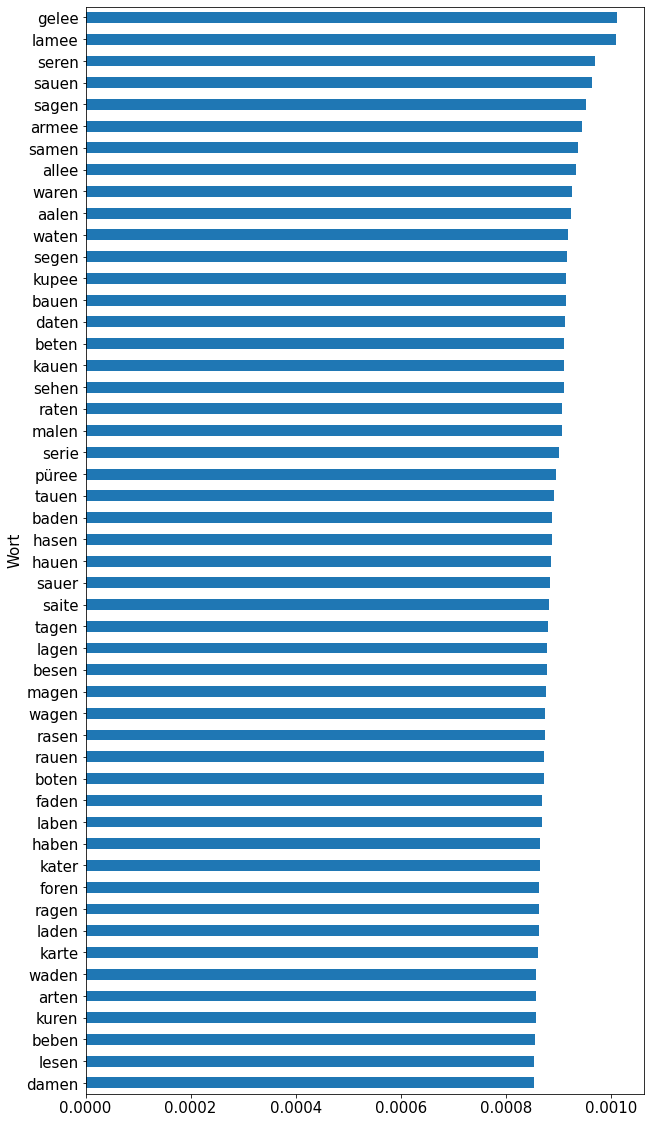

In [9]:
# Enter green letters here
white_list=[
    list(''), # 1st letter
    list(''), # 2nd letter
    list(''), # 3rd letter
    list(''), # 4th letter
    list(''), # 5th letter
]

# Enter yellow letters here
black_list=[
    list(''), # 1st letter
    list(''), # 2nd letter
    list(''), # 3rd letter
    list(''), # 4th letter
    list(''), # 5th letter
]

# Enter grey letters here. Don't put letters into this array if they also appear in green or orange in another position of the word.
black_list_all=list('')

# Get list of words sorted by probability
df_final=get_words(df_all,white_list,black_list,black_list_all)

plot_words(df_final)
